## 5.2 注意力分数

回顾在5.1小节所说的，下面式子就是注意力权重和注意力分数的表示：

![image-20220213230040974](https://s2.loli.net/2022/02/13/tfQcwxRT2DdKFa6.png)

计算注意力机制的模型总览图如下所示:
![image-20220213230051253](https://s2.loli.net/2022/02/13/LD8dCYlBZ9jwFvp.png)

### 5.2.1 扩展到高维
$m$对K-V对，$\mathbf{k}_{i} \in \mathbb{R}^{k}, \mathbf{v}_{i} \in \mathbb{R}^{v}$,query为$\mathbf{q} \in \mathbb{R}^{q}$

* 注意力池化层

$$
\begin{gathered}
f\left(\mathbf{q},\left(\mathbf{k}_{1}, \mathbf{v}_{1}\right), \ldots,\left(\mathbf{k}_{m}, \mathbf{v}_{m}\right)\right)=\sum_{i=1} \alpha\left(\mathbf{q}, \mathbf{k}_{i}\right) \mathbf{v}_{i} \in \mathbb{R}^{v} \\
\alpha\left(\mathbf{q}, \mathbf{k}_{i}\right)=\operatorname{softmax}\left(a\left(\mathbf{q}, \mathbf{k}_{i}\right)\right)=\frac{\exp \left(a\left(\mathbf{q}, \mathbf{k}_{i}\right)\right)}{\sum_{j=1}^{m} \exp \left(a\left(\mathbf{q}, \mathbf{k}_{j}\right)\right)} \in \mathbb{R}
\end{gathered}
$$

#### Additive Attention（加性注意力）

* 可学习参数

$$
\begin{aligned}
&\mathbf{W}_{k} \in \mathbb{R}^{h \times k}, \mathbf{W}_{q} \in \mathbb{R}^{h \times q}, \mathbf{v} \in \mathbb{R}^{h} \\
&a(\mathbf{k}, \mathbf{q})=\mathbf{v}^{T} \tanh \left(\mathbf{W}_{k} \mathbf{k}+\mathbf{W}_{q} \mathbf{q}\right)
\end{aligned}
$$

* 等价于将query和key合并起来后放入到一个隐藏大为h输出大小为1的单隐藏层MLP
* 好处是QKV可以是任意长度

#### Scaled Dot-Product Attention（内积注意力）

* query和key是同样长度时，$\mathbf{q}, \mathbf{k}_{i} \in \mathbb{R}^{d}$,可以

$$
a\left(\mathbf{q}, \mathbf{k}_{\mathbf{i}}\right)=\left\langle\mathbf{q}, \mathbf{k}_{\mathbf{i}}\right\rangle / \sqrt{d}
$$

* 向量化版本
  * $\mathbf{Q} \in \mathbb{R}^{n \times d}, \quad \mathbf{K} \in \mathbb{R}^{m \times d}, \mathbf{V} \in \mathbb{R}^{m \times v}$
  * 注意力分数: $a(\mathbf{Q}, \mathbf{K})=\mathbf{Q K}^{T} / \sqrt{d} \in \mathbb{R}^{n \times m}$
  * 注意力池化: $f=\operatorname{softmax}(a(\mathbf{Q}, \mathbf{K})) \mathbf{V} \in \mathbb{R}^{n \times v}$

* **更加简单常用。Transformer就是用这种方式计算注意力分数。**

### 5.2.3 代码实践

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

D:\tensorflow1\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


带掩码的softmax操作，通过在最后一个轴上掩蔽元素来执行softmax操作：

In [4]:
def masked_softmax(X, valid_lens):
    """
    通过在最后一个轴上掩蔽元素来执行softmax操作
    :param X: 3D张量
    :param valid_lens: 1D或2D张量
    :return:
    """
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)  # 给一个很小的值
        return nn.functional.softmax(X.reshape(shape), dim=-1)

masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5490, 0.4510, 0.0000, 0.0000],
         [0.6216, 0.3784, 0.0000, 0.0000]],

        [[0.4229, 0.4096, 0.1675, 0.0000],
         [0.5169, 0.2428, 0.2403, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3991, 0.3102, 0.2907, 0.0000]],

        [[0.3206, 0.6794, 0.0000, 0.0000],
         [0.2774, 0.3357, 0.2117, 0.1752]]])

* 加性注意力

In [7]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # valid_lens 看多少个前k-v对是需要的，不要padding出来的key和value
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hiddens)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [8]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

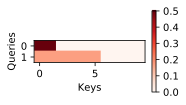

In [9]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

* 内积注意力

In [10]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [11]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

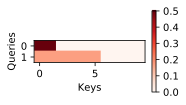

In [12]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

### 5.2.4 总结

*  注意力分数是query和key的相似度，注意力权重是分数的softmax结果
*  两个常见计算方法
   * 相加（要学两个参数，可用在Q和K维度不相同的时候）
   * 内积（不用学参数，Q和K维度要一致）